In [1]:
%load_ext autoreload
%autoreload 2
import tme4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from IPython.display import Image

# A. EM et le geyser Old Faithful

![Old_Faithful](res/Old_Faithful.jpg)

La durée des éruptions varie dans le temps ainsi que le délai entre deux éruptions consécutives. Notre hypothèse est que ces éruptions suivent en réalité deux distributions distinctes que nous allons chercher à identifier. Il s'agit donc bien d'apprentissage non supervisée d'une variable indiquant à quelle distribution se rapporte chaque éruption.

taille des données (272, 2)


Text(0, 0.5, 'Intervalle entre éruptions')

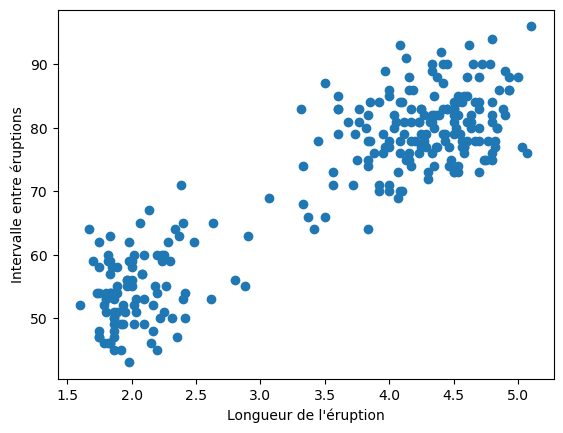

In [3]:
# chargement des données:

data = pkl.load( open('res/faithful.pkl', 'rb'))
X = data["X"] 

print("taille des données", X.shape)
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.xlabel("Longueur de l'éruption")
plt.ylabel("Intervalle entre éruptions")
# on identifie sans peine les deux distributions: c'est un cas d'école...
# ... Reste à voir si on arrive à les retrouver automatiquement


## A.1 Modélisation

Suite à la prise en main des données précédentes, nous choisissons de modéliser les deux distributions latentes par des lois normales dont il va falloir déterminer les paramètres.
La vraisemblance d'une loi normale de dimension $N$ pour une observation $\mathbf x \in \mathbb R^N$ est la suivante:

$$p(\mathbf x | \mu, \Sigma) = \frac{1}{(2 \pi)^{N / 2}|\Sigma|^{1 / 2}} e^{-\frac{1}{2}(\mathbf x-\mu) \Sigma^{-1}(\mathbf x-\mu)^{\top}}, \qquad  \mu \in \mathbb R ^N, \Sigma \in \mathbb R ^{N\times N}$$

où $|\Sigma|$ désigne le déterminant de la matrice.

### Petite vérification dimensionnelle

Vérifier rapidement au brouillon que $(x-\mu)^{\top} \Sigma^{-1}(\mathbf x-\mu)$ est bien un scalaire. Ca vous donnera des indications pour éviter les problèmes d'implémentation.

### Coder la fonction de vraisemblance

Donner le code de la `normale_bidim`:`np.array(float) x np.array(float) x np.array(float) -> float` qui prend en argument `x, mu, Sig` et qui retourne la vraisemblance.

Note: vous chercherez par vous même les fonctions numpy pour calculer le déterminant et l'inversion de matrice


In [4]:
mu  = np.array([1.,2])
Sig = np.array([[3., 0.],[0., 3.]])

x = np.array([1.,2])
print(f"{tme4.normale_bidim([1,2], mu, Sig)=}") # 0.053051647697298435
x = np.array([0,0])
print(f"{tme4.normale_bidim([0,0], mu, Sig)=}") # 0.023056151047594564

tme4.normale_bidim([1,2], mu, Sig)=0.053051647697298435
tme4.normale_bidim([0,0], mu, Sig)=0.023056151047594564


### Validation des résultats précédents

Au delà des chiffres obtenus, l'ordonnancement des deux valeurs était-il prévisible? pourquoi?

### Visualisation des isocontours de la Gaussienne

Visualiser des isocontours sur une distribution continue en 2D implique -implicitement- de travailler en 3D. La fonction suivante donne le code pour réaliser cette opération (aucun code à ajouter de votre part).

In [5]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def plot_norm_2D(mu, Sig, bounds_min = np.array([-5, -5]), bounds_max = np.array([5, 5])):
    ngrid = 30
    x = np.linspace(bounds_min[0], bounds_max[0], ngrid)
    y = np.linspace(bounds_min[1], bounds_max[1], ngrid)
    X,Y = np.meshgrid(x,y)
    Z = np.array([tme4.normale_bidim(np.array([x,y]), mu, Sig) 
                  for x,y in zip(X.flatten(), Y.flatten())]).reshape(ngrid, ngrid)
    fig = plt.gcf() # recuperation de la figure courante
    ax = fig.gca()
    ax.contour(X,Y,Z)

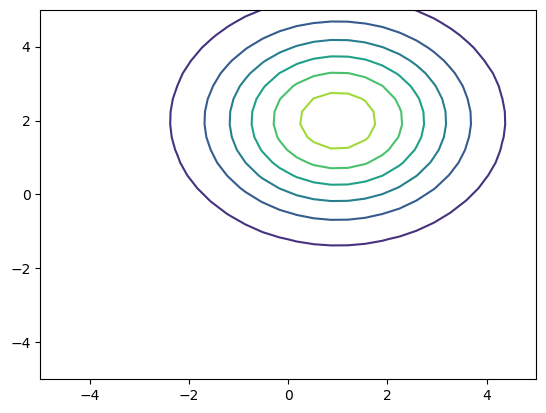

In [6]:
# test sur la distribution utilisée ci-dessus
plt.figure()
plot_norm_2D(mu, Sig)

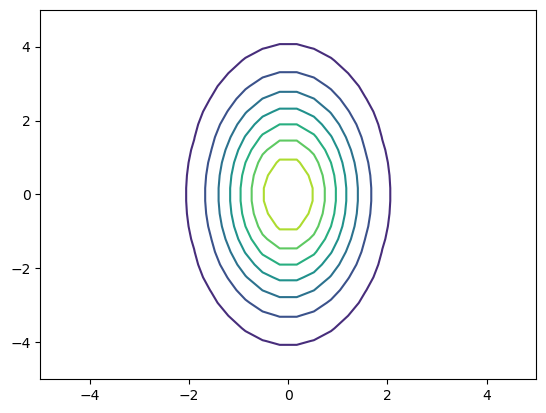

In [7]:
# autre test avec des variances très différentes sur les deux axes
mu2  = np.array([0.,0.])
Sig2 = np.array([[1., 0.],[0., 4.]])
plt.figure()
plot_norm_2D(mu2, Sig2)

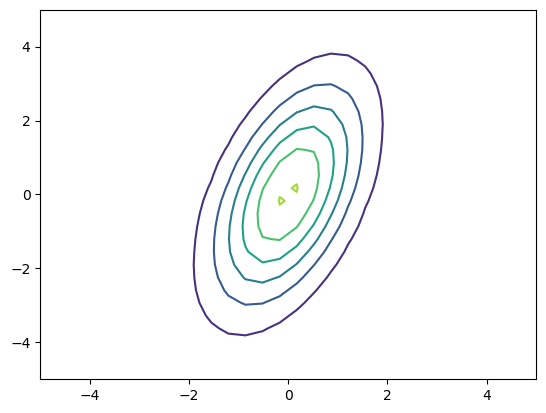

In [8]:
# dernier test avec une covariance non nulle
# Note: Attention à garder une matrice de Variance symétrique !!!
mu3  = np.array([0.,0.])
Sig3 = np.array([[1., 1.],[1., 4.]])
plt.figure()
plot_norm_2D(mu3, Sig3)

### Construction à la main d'une Gaussienne qui colle à nos données du nuage de points en haut à gauche

À la louche, on peut estimer les moyennes: (4.25, 80) sur la figure du nuage de point en haut à gauche ...

Essayer d'estimer les écarts-types et la co-variance de ce nuage.

- Estimation de l'écart-type en axe 1 : indice : 2/3 des données se trouve dans l'intervalle $[mu+std et mu-std]$
- De même, estimation de l'écart-type en axe 2
- Estimation de la co-variance: ??? 

**Note:** Attention à ne pas confondre écart-types et variances.

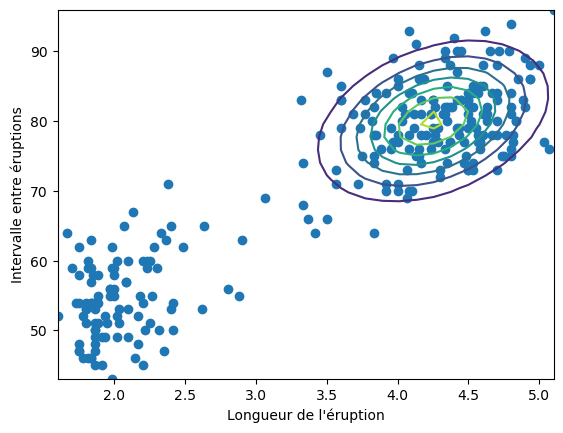

In [9]:
mu4,Sig4=tme4.estimation_nuage_haut_gauche()

plt.figure()
# tracé des points
plt.scatter(X[:,0], X[:,1])
plt.xlabel("Longueur de l'éruption")
plt.ylabel("Intervalle entre éruptions")
plot_norm_2D(mu4, Sig4, X.min(0), X.max(0) )
# plt.savefig('manual_gauss_2d.png')

## A.2 Apprentissage automatique

Arrêtons maintenant de faire des essais à la main et tentons une approche automatique qui sera:
* Robuste à des données bruitées
* Robuste à des données multi-dimensionnelles qu'on ne peut pas afficher

Nous allons utiliser une approche EM et nous utiliserons les notations suivantes.

Soit $\Theta$ les paramètres de notre modélisation normale à deux classes:

$$\Theta = \{(\pi_0 \in \mathbb R, \mu_0 \in \mathbb R^2, \Sigma_0\in \mathbb R^{2\times 2}), (\pi_1, \mu_1, \Sigma_1) \} $$
où $\pi$ désigne les probabilités a priori des classes.

Pour plus de simplicité, nous proposons de stocker tous les $\pi$ dans une seule structure de données, tous les $\mu$ dans une seule structure de données et tous les $\Sigma$ dans une structure afin de pouvoir facilement augmenter ou diminuer le nombre de classes à trouver dans le futur.

### EM : Etape 0, initialisation

$\pi = [0.5, 0.5]$ : initialisation la plus neutre et cohérente par rapport à l'observation des données

Pour $\mu$, une stratégie classique consiste à partir de la moyenne du nuage et à ajouter $1$ sur les dimensions pour $\mu_1$ et retrancher $1$ sur toutes les dimensions pour $\mu_2$.

Pour $\Sigma$, on propose de partir de la matrice de variance de l'ensemble du nuage pour les deux modèles. On propose d'initialiser une matrice 3D afin d'accéder aux matrices des modèles en faisant `Sig[0]` et `Sig[1]`

La méthode `init` prend en argument `X` et retourne `pi`, `mu` et `Sig`. 

**Note:** Si on veut une initialisation plus générique, il faut prendre en argument suppélmentaire le nombre de classes à prédire (et éventuellement d'autres choses).

In [19]:
pi, mu, Sig = tme4.init(X)
print(f"{pi=}\n{mu=}\n{Sig=}")

pi=array([0.5, 0.5])
mu=array([[ 4.48778309, 71.89705882],
       [ 2.48778309, 69.89705882]])
Sig=array([[[  1.30272833,  13.97780785],
        [ 13.97780785, 184.82331235]],

       [[  1.30272833,  13.97780785],
        [ 13.97780785, 184.82331235]]])


###  EM : l'étape E

Nous allons maintenant écrire l'étape E de l'algorithme EM, qui va nous permettre d'estimer les paramètres de la mixture de lois normales bidimensionnelles. Ainsi, comme vu en cours, soit $Y$ une variable aléatoire indiquant quelle classe/loi normale bidimensionnelle a généré le couple de données $\mathbf x \in \mathbb R^2$

Soit $\Theta^t = \{\pi^t, \mu^t, \Sigma^t\}$ les paramètres à l'itération $t$.

Pour chaque observation $\mathbf x$, on définit les $Q_i^{t+1}(y_0) = P(y_0|\mathbf x, \Theta^t)$
    $$Q_i^{t+1}(y_0) = \frac{p(\mathbf x | \mu_0, \Sigma_0) \pi_0}{\sum_{i=0}^1 p(\mathbf x | \mu_i, \Sigma_i) \pi_i},\qquad  Q_i^{t+1}(y_1) = \frac{p(\mathbf x | \mu_1, \Sigma_1) \pi_1}{\sum_{i=0}^1 p(\mathbf x | \mu_i, \Sigma_i) \pi_i}$$
    
Ecrire la fonction `Q_i: np.array x np.array x np.array x np.array -> np.array` qui prend en argument `X, pi, mu, Sig` et qui retourne le tableau des $Q_i$.

Attention, `X` correspond à l'ensemble des données, `pi` aux deux probabilités a priori, `mu` et `Sig` à des matrices contenant les paramètres des deux classes.  

In [30]:
q = tme4.Q_i(X, pi, mu, Sig)

print(f"{q[:,:5]=}") # q pour les 5 premiers points de la base

q[:,:5]=array([[0.02459605, 0.03668168, 0.05226123, 0.01630238, 0.49795917],
       [0.97540395, 0.96331832, 0.94773877, 0.98369762, 0.50204083]])


### EM : Etape M

La maximisation de la vraisemblance est l'occasion de revoir le calcul des paramètres de la loi normale bidimensionnelle en intégrant la pondération $q$.

Ainsi: 
$$ \mu_0 = \frac{\sum_i Q_i^{t+1}(y_0) \mathbf{x_i}}{\sum_i Q_i^{t+1}(y_0)}, \qquad \mu_1 = \frac{\sum_i Q_i^{t+1}(y_1) \mathbf{x_i}}{\sum_i Q_i^{t+1}(y_1)} $$

$$ \Sigma_0 = \frac{\sum_i Q_i^{t+1}(y_0) (\mathbf{x_i}-\mu_0)^T (\mathbf{x_i}-\mu_0) }{\sum_i Q_i^{t+1}(y_0)}, \qquad \Sigma_1 = \frac{\sum_i Q_i^{t+1}(y_1) (\mathbf{x_i}-\mu_1)^T (\mathbf{x_i}-\mu_1)}{\sum_i Q_i^{t+1}(y_1)} $$

Prenez le temps de dessiner les matrices pour vérifier les dimensions de $\Sigma$


Les probabilités a priori correspondent aux rapports des masses de probabilité $Q$:
$$ \pi_0 = \frac{\sum_i Q_i^{t+1}(y_0) }{\sum_i Q_i^{t+1}(y_0) + Q_i^{t+1}(y_1) }, \qquad \pi_1 = \frac{\sum_i Q_i^{t+1}(y_1) }{\sum_i Q_i^{t+1}(y_0) +  Q_i^{t+1}(y_1)} $$

Ecrire la fonction `update_param: np.array x np.array x np.array x np.array x np.array -> np.array x np.array x np.array`
qui prend en argument `X`, `q`, `pi`, `mu`, `Sig` et qui retourne une nouvelle version de `pi`, `mu`, `Sig`

In [39]:
pi_u, mu_u, Sig_u = tme4.update_param(X, q, pi, mu, Sig)

print(f"{pi_u=}\n{mu_u=}\n{Sig_u=}")

pi_u=array([0.51132321, 0.48867679])
mu_u=array([[ 3.88361418, 71.3886521 ],
       [ 3.07360826, 70.38268397]])
Sig_u=array([[[  1.04337668,  12.40444673],
        [ 12.40444673, 162.96851264]],

       [[  1.22881404,  15.10227603],
        [ 15.10227603, 205.78298546]]])


### Algorithme EM: la boucle

Alterner les itérations jusqu'à convergence, c'est à dire jusqu'à ce que les nouveaux paramètres soit très proches des anciens. Arbitrairement, on pourra faire le test de convergence sur `mu` qui est assez stable.

La méthode `EM` prend en argument `X` et retourne `nIter`, `pi`, `mu` et `Sig`. 

Elle a d'autres arguments avec des valeurs par défaut :
- `initFunc` (=tme4.init par défaut) qui est la fonction d'initialisation des paramètres `(pi,mu,sig)`
- `nIterMax` est un paramètre (=100 par défaut) pour éviter les boucles infinies. Généralement, les algorithmes itératifs de type EM sont codés avec des boucles for plutot que des while pour plus de fiabilité.
- Le paramètre `saveParam` (=None par défaut) sera utile dans les questions suivantes: ne vous en occupez pas dans un premier temps.

In [54]:
# tme4.EM(X) <==> tme4.EM(X, initFunc=tme4.init, nIterMax=100, saveParam=None)
nIter, pi, mu, Sig = tme4.EM(X)
print(f"{nIter=}\n\n{pi=}\n{mu=}\n{Sig=}")

nIter=22

pi=array([0.64412529, 0.35587471])
mu=array([[ 4.28966596, 79.96816344],
       [ 2.03639296, 54.47856174]])
Sig=array([[[ 0.16996337,  0.94054489],
        [ 0.94054489, 36.04548599]],

       [[ 0.06917125,  0.43520499],
        [ 0.43520499, 33.69753693]]])


### Affichage du résultat

A l'issue des itérations, vous devez obtenir la figure suivante:

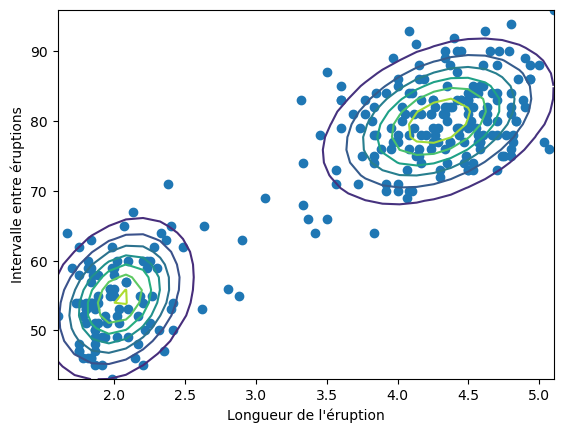

In [55]:
plt.figure()

plt.scatter(X[:,0], X[:,1])
plt.xlabel("Longueur de l'éruption")
plt.ylabel("Intervalle entre éruptions")
plot_norm_2D(mu[0], Sig[0], X.min(0), X.max(0) ) # affichage modèle 1
plot_norm_2D(mu[1], Sig[1], X.min(0), X.max(0) ) # affichage modèle 2
plt.savefig('res_EM.png')

## A-3 Réalisation d'une animation sur la convergence du modèle

L'idée est d'utiliser le paramètre `saveParam` de la méthode EM pour savegarder les paramètres du modèle à chaque itération et pouvoir retracer toutes les figures correspondant à toutes les étapes de l'algorithme.

* il faut sauver les figures dans un répertoire à part, sinon ça va être le bazar dans votre répertoire
* il faut donner des noms de fichiers explicites pour pouvoir récupérer les informations dans l'ordre ensuite
* il faut utiliser pickle, car la sérialisation c'est fantastique dans ce genre de cas de figure.


L'idée est d'invoquer: `pi, mu, Sig = tme4.EM(X, saveParam="params/faithful")`

Il faudra créer le sous-répertoire `params` puis sauver les paramètres dans:
`params/faithful1.pkl`, `params/faithful2.pkl`, ...
 
Afin de respecter toutes les contraintes, nous vous proposons d'insérer le code suivant dans la méthode EM:
```
import os # ajout de bibliothèque utile avant la méthode

        if saveParam is not None:                                         # détection de la sauvergarde
            if not os.path.exists(saveParam[:saveParam.rfind('/')]):     # création du sous-répertoire
                 os.makedirs(saveParam[:saveParam.rfind('/')])
            pkl.dump({'pi':pi_u, 'mu':mu_u, 'Sig': Sig_u},\
                     open(saveParam+str(i)+".pkl",'wb'))                 # sérialisation
```

**Note:** tout le code est donné... Mais il faut vérifier que vous sauvez bien les bonnes variables (j'ai mis les noms que j'ai utilisé dans la correction et qui ne correspondent pas forcément.

In [63]:
nIter, pi, mu, Sig = tme4.EM(X, saveParam="params/faithful")


Il faut ensuite créer la méthode qui va charger ces paramètres et créer l'animation... Le code est fourni ci-dessous.

Le code est capricieux... Mais si ça marche, vous devez obtenir:

![old_faithful.gif](res/old_faithful.gif)

In [64]:
import matplotlib.animation as animation
import glob


def creer_animation(X, params_path, fname):
    nbiter = len(glob.glob(params_path+"/*.pkl"))
    print(f"{nbiter=}")
    fig = plt.figure()
    plt.xlim(X[:,0].min()-(X[:,0].mean()*0.05), X[:,0].max()+(X[:,0].mean()*0.05))
    plt.ylim(X[:,1].min()-(X[:,1].mean()*0.05), X[:,1].max()+(X[:,1].mean()*0.05))
    plt.xlabel("Longueur de l'éruption")
    plt.ylabel("Intervalle entre éruptions")

    def animate(i):
        print("." if i%5!=0 else "#",end="")
        data = pkl.load(open(params_path+"/"+fname+str(i)+".pkl","rb")) # récupération d'un dictionnaire
        plt.clf()
        ax  = fig.gca()
        ax.scatter(X[:,0], X[:,1])
        ax.text(X[:,0].max()*0.75, X[:,1].min()*1.25, 'step = ' + str ( i ))
        for i in range(len(data['mu'])):
            plot_norm_2D(data['mu'][i], data['Sig'][i], X.min(0), X.max(0) ) # affichage modèle i
        
        return ax

    ani = animation.FuncAnimation(fig, animate, frames = nbiter, interval=300, repeat=True )
    ani.save(f'{params_path}/animation.gif', bitrate=4000)
    plt.close()


creer_animation(X, "params", "faithful")

Image(url='params/animation.gif')


nbiter=23
##....#....#....#....#..

## A-4 Impact de l'initialisation

EM est très souvent associé à des formalismes non convexes... Ca sinifie que les maxima sont multiples et qu'une mauvaise initialisation peut avoir des conséquences désastreuses...

Imaginons une nouvelle fonction d'initialisation où les moyennes initiales sont initialisées de manière défavorable , c'est à dire orthogonalement à la séparabilité naturelle des données.

Les données sont vraiment très facile à séparer et le code va continuer à fonctionner... Mais on note que la convergence est bien moins rapide.

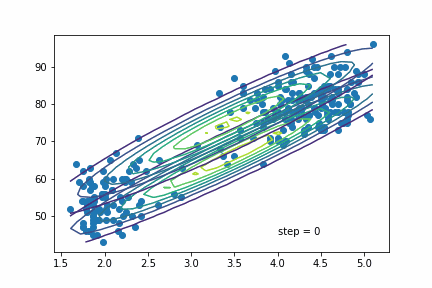

In [65]:
def bad_init(X):
    pi = np.array([0.5, 0.5]) # le plus raisonnable dans l'absolu et cohérent avec les observations

    mu1 = X.mean(0)+ [0.1,-15] # initialisation défavorable
    mu2 = X.mean(0)+ [-0.1,15]
    mu  = np.vstack((mu1, mu2))

    Sig = np.zeros((2, 2, 2))
    Sig[0,:,:] = np.cov(X.T)
    Sig[1,:,:] = np.cov(X.T)
    return pi, mu, Sig

nIter, pi, mu, Sig = tme4.EM(X, initFunc=bad_init,saveParam="params_bad/faithful")

creer_animation(X, "params_bad", "faithful")

Image(url='params_bad/animation.gif')



nbiter=69
##....#....#....#....#....#....#....#....#....#....#....#....#....#...

# B- Passage en 4 classes

Nous vous proposons un nouveau jeu de données (jouet) où il y a 4 classes à découvrir.
Adapter votre code pour faire face à ce cas de figure.

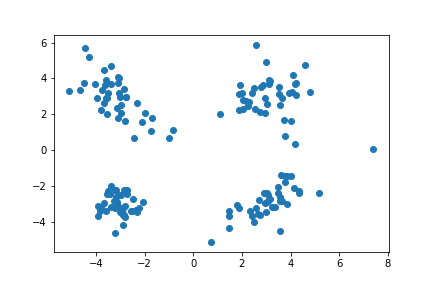

ON commence par proposer un modèle de génération de données (aléatoires) créant un nuage de points séparées en 4 sous-nuages plus ou moins séparés :

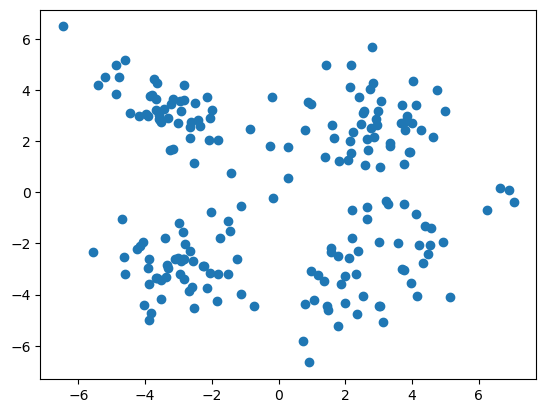

In [69]:
np.random.seed(0)

def generation_4_gaussiennes():
    n = 50 # nb points par gaussienne
    
    Sig1 = np.array([[1, 0],[0, 1]])
    mu1  = np.array([-3, -3])
    Sig2 = np.array([[1.5, 0.5],[0.5, 1.5]])
    mu2  = np.array([3, -3])
    Sig3 = np.array([[1.2, -0.5],[-0.5, 1.2]])
    mu3  = np.array([-3, 3])
    Sig4 = np.array([[1.2, 0],[0, 1.2]])
    mu4  = np.array([3, 3])
    
    X = np.vstack((np.random.randn(n,2)@Sig1 +mu1, np.random.randn(n,2)@Sig2 +mu2,\
                   np.random.randn(n,2)@Sig3 +mu3, np.random.randn(n,2)@Sig4 +mu4))
    return X

Xg = generation_4_gaussiennes()

plt.figure()
plt.scatter(Xg[:,0],Xg[:,1]);
#plt.savefig("data_gauss.png")

Si votre code est robuste, il suffit de changer l'initialisation dans la fonction `tme4.init_4`:

* pi = 4 modalités équi-probables
* mu = 4 vecteurs de dimension 2 décalés de la moyenne globale de [1,1], [-1,1], [1,-1], [-1,-1]
* Sig = Matrice des variances de l'ensemble du nuage pour toutes les classes

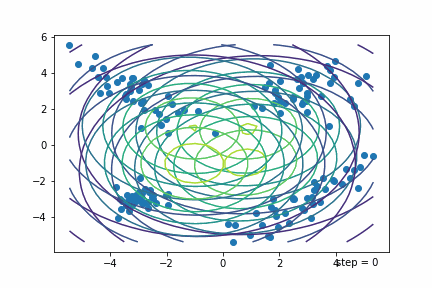

In [71]:
print(tme4.init_4(X))

(array([0.25, 0.25, 0.25, 0.25]), array([[ 4.48778309, 71.89705882],
       [ 2.48778309, 71.89705882],
       [ 4.48778309, 69.89705882],
       [ 2.48778309, 69.89705882]]), array([[[  1.30272833,  13.97780785],
        [ 13.97780785, 184.82331235]],

       [[  1.30272833,  13.97780785],
        [ 13.97780785, 184.82331235]],

       [[  1.30272833,  13.97780785],
        [ 13.97780785, 184.82331235]],

       [[  1.30272833,  13.97780785],
        [ 13.97780785, 184.82331235]]]))


Il devrait maintenant suffire de lancer EM sur cette nouvelle initialisation

In [72]:
nIter,pi, mu, Sig = tme4.EM(Xg, initFunc=tme4.init_4,saveParam="params_gauss/gauss")

creer_animation(Xg, "params_gauss", "gauss")
Image(url='params_gauss/animation.gif')

nbiter=27
##....#....#....#....#....#.

### passage à une initialisation dégradée

* dans `tme4.bad_init_4` : mu = 4 vecteurs de dimension 2 décalés de la moyenne globale de $[4,2], [3,4], [0,0], [-5,0]$


Quand on part de n'importe où, on n'arrive pas forcément au bon endroit (attention, le résultat ne sera pas le même que sur ce nuage aléatoire) :

![gauss_bad.gif](res/gauss_bad.gif)


In [73]:
nIter, pi, mu, Sig = tme4.EM(Xg, initFunc=tme4.bad_init_4, saveParam="params_gauss_bad/gauss")

creer_animation(Xg, "params_gauss_bad", "gauss")
Image(url='params_gauss_bad/animation.gif')

nbiter=63
##....#....#....#....#....#....#....#....#....#....#....#....#..

# C- Passage en haute dimension

Au delà de 2 ou 3 dimensions, il n'est plus question de visualiser le nuage de points... Cela peut poser des problèmes pour la compréhension générale du problème, la détermination du nombre de classes, les intuitions pour l'initialisation des paramètres.

Bref, on franchit un pallier de complexité important.

### C-1 Application sur les données USPS de la semaine 3

Reprenons les données de la semaine 3 mais en mode non supervisé: nous observons les $X$ mais il n'y a plus de $Y$ (du moins, plus pour l'algorithme d'apprentissage, on pourra toujours s'en servir pour l'évaluation).

### C-1.2 Choix d'une modélisation

Nous n'allons pas faire l'hypothèse d'une gaussienne en 256 dimensions pour représenter une image... Il faut donc choisir un modèle.
Par défaut, nous allons reprendre la modélisation de Bernoulli (mais vous pouvez optez pour la modélisation gaussienne par pixel, ça ne change pas grand chose).

Il y a donc un paramètre $p_j$ par pixel et par classe à déterminer.

**Note:** le modèle étant différent, on doit refaire toutes les méthodes

* Nous vous donnons le code de chargement des données
* Nous vous donnons la fonction de calcul de la log-vraisemblance d'une image pour un modèle de classe de type Bernoulli (calcul de $\log  p(X | \theta)$)
* Vous devez refaire une fonction d'initialisation `init_B(X)`
    - par exemple en moyennant 3 images consécutives à partir du début de la base 10 fois de suite pour obtenir des paramètre theta
* Vous devez refaire une fonction `Q_i_B(X, pi , theta)` qui retourne des 1 pour la plus forte proba et des 0 ailleurs (il s'agit donc d'une affectation en dure à la classe majoritaire.

En effet, nous utilisons normalement:
$$ p(\theta | X) = \frac{p(X | \theta) p(\theta)}{\sum_c p(X | \theta_c) p(\theta_c)} $$
Ne disposant que de $\log(p(X | \theta))$, la formule devient:
$$ \log p(\theta | X) = \log(p(X | \theta)) + \log( p(\theta)) - \log \left(\sum_c p(X | \theta_c) p(\theta_c)\right) $$
Le dénominateur (ou partie négative du log) est compliqué à calculer car on ne peut pas faire rentrer le log dans la somme.

Nous allons utiliser le *logsumexp trick* pour résoudre ce problème:
$$\log \sum_z p(x,z)=s^*+\log \sum_z \exp (\log p(x,z) - s^*), \qquad s^* = \max_z \log p(x,z) $$




* la fonction `update_param_B(X, q, pi, theta)` est quasi-identique à la précédente, les theta étant obtenus comme les mu en pondérant le calcul de la moyenne par l'appartenance du point à la classe.

* La fonction `EM_B` est quasi-inchangée... Mais la convergence est trop lente. Le critère prévu initialement était trop strict (une somme de valeurs absolues augmente mécaniquement avec le nombre de paramètres). Ca vaut le coup de changer et de regarder seulement le plus grand changement:
```
np.abs(theta-theta_u).sum()<1e-3   =>   np.abs(theta-theta_u).max()<1e-3
```

**Note importante:** Prendre le temps de réfléchir à la raison qui rend impossible le retour vers la formulation initiale en prenant simplement $p(\theta | X) = \exp (\log  p(X | \theta))$.



In [ ]:
# chargement des données
data = pkl.load(open("res/usps.pkl",'rb')) 
# data est un dictionnaire contenant les champs explicites X_train, X_test, Y_train, Y_test
Xu = np.array(data["X_train"],dtype=float) # changement de type pour éviter les problèmes d'affichage
Xu = np.where(Xu>0, 1, 0) # binarisation
Yu = data["Y_train"]

Définir les fonctions `logobsBernoulli(X,theta)` et `init_B(X)`

In [ ]:
pi, theta = tme4.init_B(Xu)

print(f"{pi=}\n{theta=}\n\n")

print(f"LL(première image , classe0)={tme4.logpobsBernoulli(Xu[0],theta[0])}")

In [ ]:
q = tme4.Q_i_B(Xu, pi, theta)
print(q)
# Les 3 premières images sont attribuées au cluster 0 de manière certaine...
# ... C'est normal, elles ont servi à initialiser le cluster !

In [ ]:
pi_u, theta_u = tme4.update_param_B(Xu, q, pi, theta)
print(pi_u,"\n", theta_u)

In [ ]:
# tme4.EM_B(Xu) == tme4.EM_B(Xu,initFunc=init_B,nIterMAx=100,saveParam=None)
nIter,pi, theta = tme4.EM_B(Xu)
print(f"{nIter=}\n{pi=}\n{theta=}")

### C-2 Reflexion sur les métriques d'évaluation en clustering

Etape d'affectation des points à une classe: il s'agit juste de faire tourner `Q_i_B` une fois de plus pour trouver des $\hat Y$.

**Problème** : rien ne garantit que le $Y == 0$ corresponde au $\hat Y == 0$

**Proposition de métrique: la pureté**
1. Déterminer la classe majoritaire dans chaque cluster
1. Calculer la pureté du cluster = le pourcentage d'image dans le cluster qui appartiennent à la classe majoritaire du cluster.
    - L'idée est de travailler sur `Y_hat_c = Y[Y_hat == c]` : les vraies étiquettes associées à un cluster
    - Pour compter les étiquettes dans `Y_hat_c`, le plus simple est d'utiliser: `val, count = np.unique(Y_hat_c, return_counts=True)`
1. Agréger les puretés en pondérant par la taille (le 'poids') du cluster pour obtenir un indicateur unique


**Note:** la pureté est une métrique intéressante pour comparer deux partitionnements des données... A condition de travailler à nombre de partitions fixes. En effet, plus il y a de clusters, plus c'est facile d'avoir une pureté élevée!

In [ ]:
purete, poids = tme4.calcul_purete(Xu, Yu, pi, theta)

print(f"{purete=}\n{poids=}\n{((purete*poids)/poids.sum()).sum()=}")